#Exam Assignment

## Importing Libraries

In [ ]:
import requests
import zipfile
import io
import altair as alt

# Standard Libraries for Data Manipulation
import pandas as pd  # For data manipulation
import numpy as np  # For numerical computations

# Data Visualization Libraries
import matplotlib.pyplot as plt  # For custom graphs at the end
import seaborn as sns  # For visualizing data patterns and trends

# System and OS Utilities
import os  # Needed for handling environment variables (e.g., in Domino)

# Supervised Machine Learning (SML) Libraries
import sklearn  # General machine learning utilities
from sklearn.ensemble import RandomForestClassifier  # Example of ensemble models
from sklearn.model_selection import train_test_split  # For creating train/test splits
from sklearn import datasets  # Loading datasets (e.g., Boston Housing Data)

# Explainable AI (XAI) Tools
# Install necessary packages for explanation tools
!pip install lime shap pdpbox -qqq
!pip install yellowbrick==1.5

import lime  # LIME: Local Interpretable Model-agnostic Explanations
import lime.lime_tabular  # Tabular data explanation with LIME
import shap  # SHAP: SHapley Additive exPlanations
import yellowbrick as yb  # Visualization tools for machine learning models
from pdpbox import pdp  # Partial dependence plots for model interpretation

## Importing Data

In [ ]:
zip_url_1= "https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_0.csv.zip"
zip_url_2= "https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_1.csv.zip"
zip_url_3= "https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_2.csv.zip"

    # Download the ZIP file
response = requests.get(zip_url_1)
response.raise_for_status()  # Check if the request was successful

# Open the ZIP file from the response content
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
     # List all files in the ZIP
    print(zf.namelist())

        # Read a specific CSV file from the ZIP
    df1 = pd.read_csv(zf.open('kiva_loans_part_0.csv'))


    # Download the ZIP file
response = requests.get(zip_url_2)
response.raise_for_status()  # Check if the request was successful

    # Open the ZIP file from the response content
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
        # List all files in the ZIP
    print(zf.namelist())

        # Read a specific CSV file from the ZIP
    df2 = pd.read_csv(zf.open('kiva_loans_part_1.csv'))

    # Download the ZIP file
response = requests.get(zip_url_3)
response.raise_for_status()  # Check if the request was successful

    # Open the ZIP file from the response content
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
        # List all files in the ZIP
    print(zf.namelist())

        # Read a specific CSV file from the ZIP
    df3 = pd.read_csv(zf.open('kiva_loans_part_2.csv'))

['kiva_loans_part_0.csv', '__MACOSX/._kiva_loans_part_0.csv']
['kiva_loans_part_1.csv', '__MACOSX/._kiva_loans_part_1.csv']
['kiva_loans_part_2.csv', '__MACOSX/._kiva_loans_part_2.csv']


In [ ]:
data = pd.concat([df1, df2, df3])

## EDA

Kiva is a crowdfunding platform to extend financial services to poor and financially excluded people around the world.

We have selected the dataset containg information about loans, but do not include the data about ids, mpi and region since the most of this is already included in the main datafile.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 671205 entries, 0 to 221204
Data columns (total 20 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  671205 non-null  int64  
 1   funded_amount       671205 non-null  float64
 2   loan_amount         671205 non-null  float64
 3   activity            671205 non-null  object 
 4   sector              671205 non-null  object 
 5   use                 666973 non-null  object 
 6   country_code        671197 non-null  object 
 7   country             671205 non-null  object 
 8   region              614405 non-null  object 
 9   currency            671205 non-null  object 
 10  partner_id          657698 non-null  float64
 11  posted_time         671205 non-null  object 
 12  disbursed_time      668809 non-null  object 
 13  funded_time         622874 non-null  object 
 14  term_in_months      671205 non-null  float64
 15  lender_count        671205 non-null  in

The loan data contains 671250 entries. These entries are either in hole numbers (int64), numbers (float64) and text (objects).

The data has information about how much of a loan that Kiva has funded, which sector, activity and use these loans has been disbursted for, the country and region the borrower comes from, when the loan was disbursed and for how long the loan has been running. Moreover it is possible to see which gender the borrower has and the repayment plan for the loan.

The data is used to get an idea of which gender and sector that borrows the most money.

### Data Cleaning

In [ ]:
data.drop(['tags'], axis = 'columns', inplace = True) #Removing tags from dataframe
data.dropna(inplace = True) #removing Na values
print(data.isna().sum())

id                    0
funded_amount         0
loan_amount           0
activity              0
sector                0
use                   0
country_code          0
country               0
region                0
currency              0
partner_id            0
posted_time           0
disbursed_time        0
funded_time           0
term_in_months        0
lender_count          0
borrower_genders      0
repayment_interval    0
date                  0
dtype: int64


Assessing the gender variable

In [ ]:
valid_genders = ['male', 'female']
data = data[data['borrower_genders'].isin(valid_genders)]
data.borrower_genders.value_counts()

,count
borrower_genders,
female,377744
male,103365


We will now plot the distribution of the data

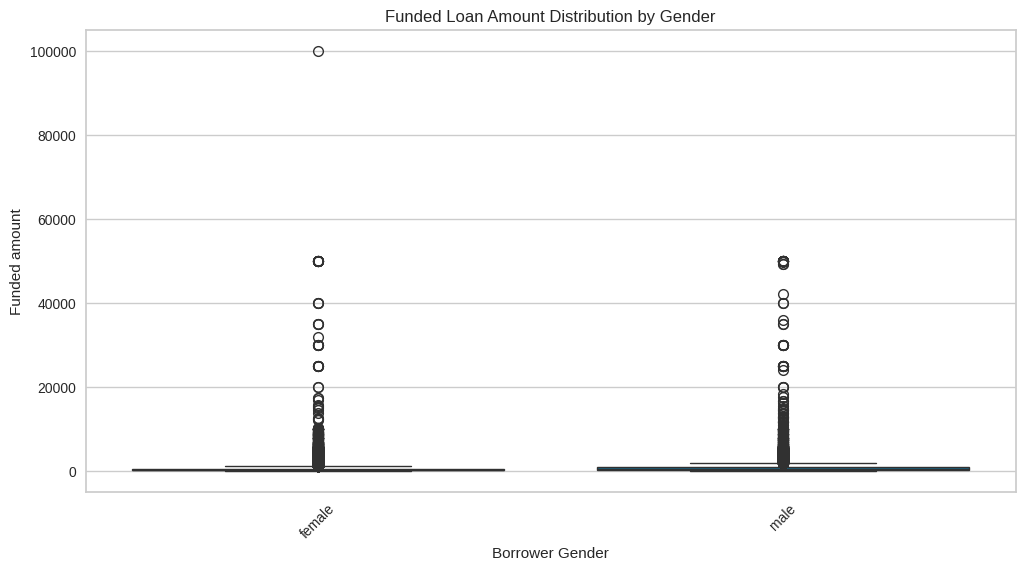

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='borrower_genders', y='funded_amount', data=data, order=data['borrower_genders'].value_counts().index)
plt.title('Funded Loan Amount Distribution by Gender')
plt.xlabel('Borrower Gender')
plt.ylabel('Funded amount')
plt.xticks(rotation=45)
plt.show()

The data shows a wide range of funded amounts of loans and several outliers. Therefore we will be using IQR to remove the outliers from our dataset.

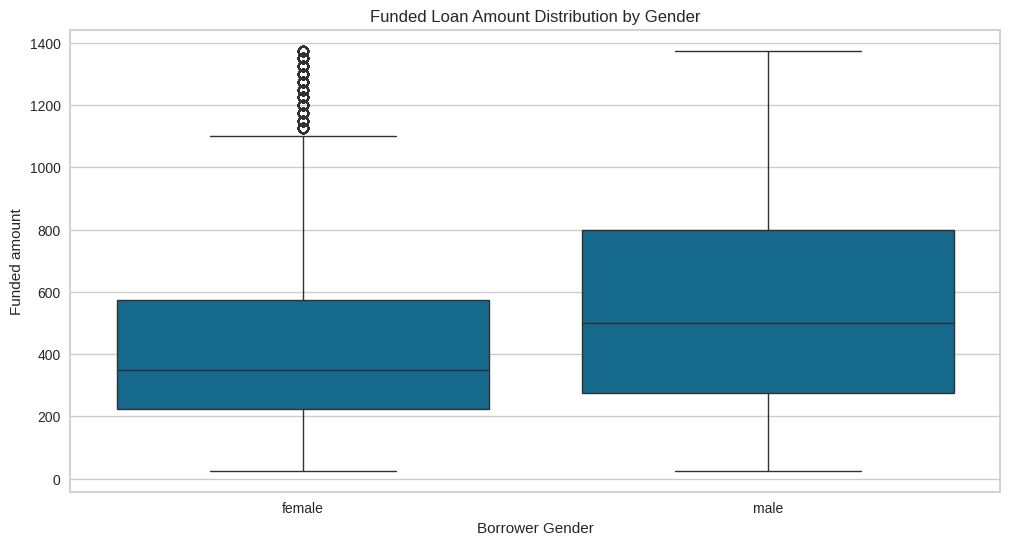

In [ ]:
#Defining the first and third quantile of the dataset
Q1 = data['funded_amount'].quantile(0.25)
Q3 = data['funded_amount'].quantile(0.75)
IQR = Q3 - Q1

# Create a mask to identify outliers
outlier = (data['funded_amount'] < (Q1 - 1.5 * IQR)) | (data['funded_amount'] > (Q3 + 1.5 * IQR))

# Remove outliers from the DataFrame
data = data[~outlier]

#Now we will plot and see the distribution of the variables:
plt.figure(figsize=(12, 6))
sns.boxplot(x='borrower_genders', y='funded_amount', data=data, order=data['borrower_genders'].value_counts().index)
plt.title('Funded Loan Amount Distribution by Gender')
plt.xlabel('Borrower Gender')
plt.ylabel('Funded amount')
plt.xticks(rotation=0)
plt.show()

The figure summarizes the distribution of funded loan amounts for the genders male and female. Female borrowers have a lower mean than male borrowers and there are more male borrowers in third quantile than female borrowers.

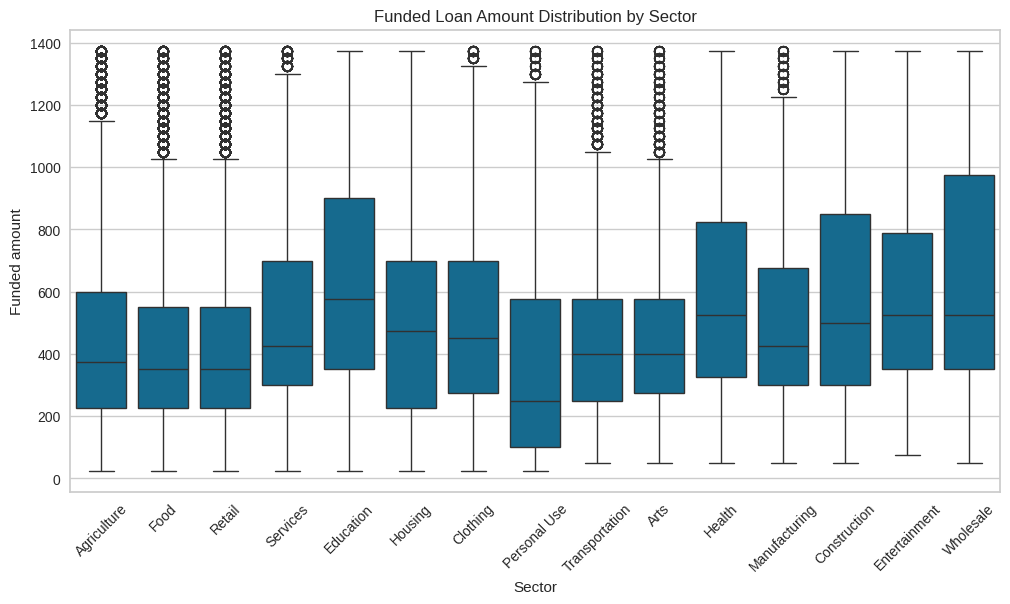

In [ ]:
#Now we will plot and see the distribution of the variables:
plt.figure(figsize=(12, 6))
sns.boxplot(x='sector', y='funded_amount', data=data, order=data['sector'].value_counts().index)
plt.title('Funded Loan Amount Distribution by Sector')
plt.xlabel('Sector')
plt.ylabel('Funded amount')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
data.groupby(['borrower_genders','sector'])[['funded_amount','term_in_months','lender_count']].agg(['mean','var','min','median','max','sum','std'])

funded_amount                               \
                                         mean            var    min median   
borrower_genders sector                                                      
female           Agriculture       442.522075   83095.886119   25.0  350.0   
                 Arts              445.179796   67374.957174   50.0  400.0   
                 Clothing          510.729780   92363.543820   25.0  450.0   
                 Construction      511.758424   92266.410274   50.0  425.0   
                 Education         600.016337  106814.818918   25.0  550.0   
                 Entertainment     515.807560   73977.707667   75.0  450.0   
                 Food              410.613185   69341.800487   25.0  325.0   
                 Health            571.098416  105749.221740   50.0  500.0   
                 Housing           474.443127   85560.392588   25.0  425.0   
                 Manufacturing     442.135018   64096.055616   50.0  400.0   
                 Personal Use      359.809511  104289.777084   25.0  225.0   
                 Retail            418.133050   71053.352873   25.0  325.0   
                 Services          491.284761   81889.061901   25.0  400.0   
                 Transportation    421.047128   54830.802687   50.0  375.0   
                 Wholesale         558.105469   93975.710401   50.0  475.0   
male             Agriculture       507.726952  107693.486362   25.0  425.0   
                 Arts              577.788221  114746.764378   50.0  500.0   
                 Clothing          605.378486  106134.673929   25.0  550.0   
                 Construction      664.995347  114666.503703   50.0  625.0   
                 Education         640.983700  112623.040432   25.0  600.0   
                 Entertainment     700.127551  106471.137493   75.0  662.5   
                 Food              570.291078  102333.719716   50.0  500.0   
                 Health            618.351477  101545.180341   75.0  600.0   
                 Housing           615.542938   93700.326303   25.0  575.0   
                 Manufacturing     647.564022  107389.374805   75.0  600.0   
                 Personal Use      387.123299  106376.559580   25.0  250.0   
                 Retail            572.721640  102585.854571   50.0  500.0   
                 Services          625.565783  108103.564971   50.0  575.0   
                 Transportation    525.644699  102795.643643   50.0  450.0   
                 Wholesale         766.610738  131010.225830  100.0  800.0   

                                                                 \
                                    max         sum         std   
borrower_genders sector                                           
female           Agriculture     1375.0  37536050.0  288.263571   
                 Arts            1375.0   3181700.0  259.566865   
                 Clothing        1375.0   8594050.0  303.913711   
                 Construction    1375.0   1078275.0  303.753865   
                 Education       1375.0   8263425.0  326.825365   
                 Entertainment   1375.0    150100.0  271.988433   
                 Food            1375.0  35015450.0  263.328313   
                 Health          1375.0   2199300.0  325.191054   
                 Housing         1375.0   8200275.0  292.507081   
                 Manufacturing   1375.0   1329500.0  253.171988   
                 Personal Use    1375.0   2776650.0  322.939278   
                 Retail          1375.0  34704625.0  266.558348   
                 Services        1375.0  11341800.0  286.162649   
                 Transportation  1375.0   3019750.0  234.159780   
                 Wholesale       1375.0    142875.0  306.554580   
male             Agriculture     1375.0  17248500.0  328.166858   
                 Arts            1375.0    461075.0  338.742918   
                 Clothing        1375.0    911700.0  325.783170   
                 Construction    1375.0   1429075.

The table summarizes key statistical metrics for various sectors and gender groups based on their funded amounts, loan terms, and lender counts. For each sector (e.g., Agriculture, Arts, Clothing), values such as mean, variance, minimum, median, maximum, sum, and standard deviation are presented, providing a comprehensive overview of loan characteristics.

For example, in the Agriculture sector, female borrowers received an average loan amount of 442.52, with a variance of 83,095. The maximum loan was 1375.00, while the sum total of funded loans was 1,137,472.0. In contrast, the Retail sector for male borrowers shows a higher average loan amount of 572.72, with a maximum of 1375.00 and a total sum of 147,251.00

These metrics reveal sector-specific funding trends and gender-based differences in loan distribution across multiple industries, highlighting significant variations in both loan amounts and lender counts.

## Correlation plot

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical variables
le_activity = LabelEncoder()
le_sector = LabelEncoder()
le_country = LabelEncoder()
le_gender = LabelEncoder()
le_repayment = LabelEncoder()

data['activity_id'] = le_activity.fit_transform(data['activity'])
data['country_id'] = le_country.fit_transform(data['country'])
data['sector_id'] = le_sector.fit_transform(data['sector'])
data['gender_id'] = le_gender.fit_transform(data['borrower_genders'])
data['repayment_id'] = le_repayment.fit_transform(data['repayment_interval'])

In [ ]:
data.drop(['posted_time','disbursed_time', 'funded_time', 'date', 'country_code' , 'use', 'region', 'currency'], axis = 'columns', inplace = True)
data.dropna(inplace = True)
data_subset = data.drop(['id','partner_id','activity','sector','country', 'borrower_genders', 'repayment_interval'], axis = 'columns')

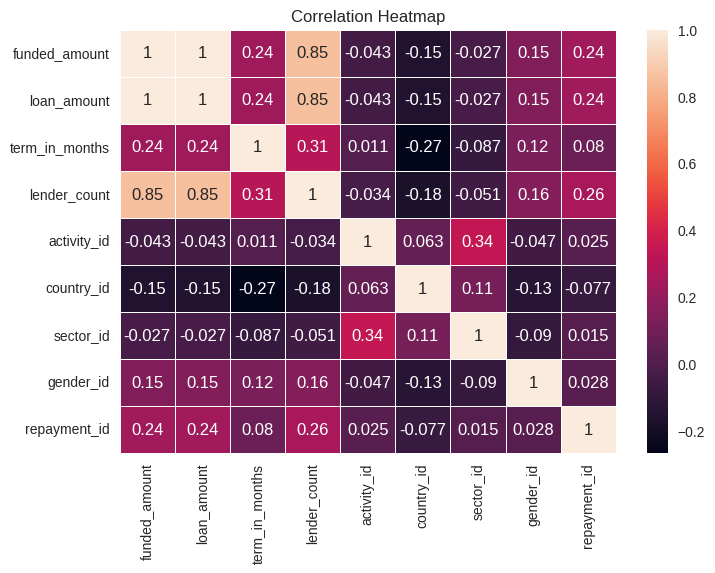

In [ ]:
sns.heatmap(data_subset.corr(), annot=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The heatmap shows the correlation across the variables in the dataset. It show that the amount funded is strongly and positively correlated with the numbers of leders.

The following variable activity_id, country_id, sector_id and gender_id show a weak correlatation with all the other variables indicating that these does not have a direct effect on the loan size, term in months or the number of lenders.

## Cluster

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Standardizing the data
scaler = MinMaxScaler()
data_data_scaled = scaler.fit_transform(data_subset)

We are employing a MinMaxScaler to normalize the dataset, ensuring that all features are standardized and contribute equally to distance metrics in the subsequent clustering analysis. Following the scaling process, we utilize the elbow method to determine the optimal number of clusters. This involves evaluating the inertia across a range of cluster numbers and identifying the point at which further increases in the number of clusters yield diminishing returns in reducing the distortion score.

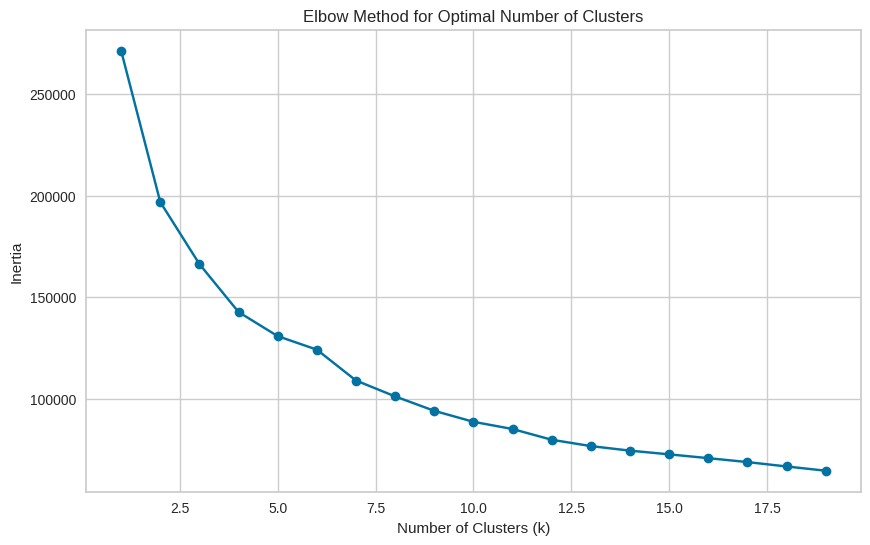

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Initialize variables
inertia_values = []
k_range = range(1, 20)  # We will check for up to 20 clusters

# Run K-means with different k values and store the inertia (sum of squared distances)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_data_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

We select 3 as the number of clusters.

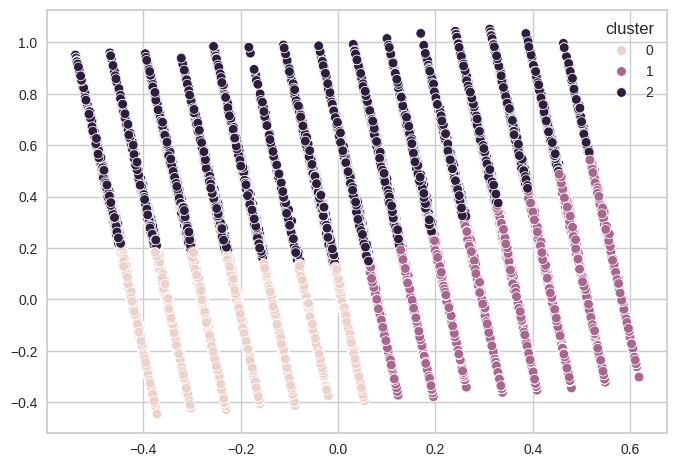

In [ ]:
from sklearn.cluster import KMeans

data_data_scaled_df_X = pd.DataFrame(data_data_scaled, columns=data_subset.columns)

X = data_data_scaled_df_X[['funded_amount', 'sector_id', 'lender_count']].values

k = 3

# Fit the K-Means model
kmeans = KMeans(n_clusters=k)
data['cluster'] = kmeans.fit_predict(X)

# Get cluster labels and centroids
cluster_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=data['cluster'])
plt.show()

## Supervised ML Algorithm Model Selection and Training

In [ ]:
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
X = data[['sector','country', 'term_in_months', 'lender_count', 'borrower_genders']]
y = data['funded_amount']

# One-hot encode categorical variables
ohe = OneHotEncoder() # be careful - output is a sparse matrix
cat_features = ['sector', 'country', 'borrower_genders' ]
X_cat = pd.DataFrame(ohe.fit_transform(X[cat_features]).todense(), columns=ohe.get_feature_names_out(cat_features))

# Scale numerical features
scaler = MinMaxScaler()
num_features = ['term_in_months', 'lender_count']
X_num = pd.DataFrame(scaler.fit_transform(X[num_features]), columns=num_features)

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([X_num, X_cat], axis=1) #we are combining our processed categorical and numerical data by the rows

print("Shape of processed features:", X_processed.shape)
X_processed.head()

Shape of processed features: (446253, 91)


,term_in_months,lender_count,sector_Agriculture,sector_Arts,sector_Clothing,sector_Construction,sector_Education,sector_Entertainment,sector_Food,sector_Health,...,country_Turkey,country_Uganda,country_Ukraine,country_United States,country_Vietnam,country_Yemen,country_Zambia,country_Zimbabwe,borrower_genders_female,borrower_genders_male
0,0.076336,0.203704,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.312977,0.092593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.068702,0.129630,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.091603,0.277778,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.312977,0.129630,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Small_X_processed = X_processed.head(5000)
Small_y = y.head(5000)

X_train, X_test, y_train, y_test = train_test_split(Small_X_processed, Small_y, test_size = 0.2)

model_ols = LinearRegression()
model_el = ElasticNet()
model_rf = RandomForestRegressor(n_estimators=25)
model_ols.fit(X_train, y_train)
model_el.fit(X_train, y_train)
model_rf.fit(X_train, y_train)


print('Model OLS' + ' ' + str(model_ols.score(X_test, y_test)))
print('Model EL' + ' ' + str(model_el.score(X_test, y_test)))
print('Model RF' + ' ' + str(model_rf.score(X_test, y_test)))

Model OLS -4.956304885293594e+17
Model EL 0.20977255514598614
Model RF 0.8583671385311691


### Hyperparameter Tuning

#### EL

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# scorer = make_scorer(r2_score)
scorer = make_scorer(mean_squared_error)

parameters_el = {'alpha':[0.1, 0.5, 1.0],
                 'l1_ratio':[0.1, 0.5, 0.75]}

# Perform grid search on the classifier using 'scorer' as the scoring method.
grid_obj = GridSearchCV(model_el, parameters_el, scoring=scorer)

grid_fit = grid_obj.fit(Small_X_processed, Small_y)

# Get the estimator.
best_reg = grid_fit.best_estimator_

# Fit the new model.
best_reg.fit(X_train, y_train)
print('EL Train performance: ' + str(best_reg.score(X_train, y_train)))
best_reg.score(X_test, y_test)
print('EL Test performance: ' + str(best_reg.score(X_test, y_test)))

EL Train performance: 0.1311764493655193
EL Test performance: 0.13582128037632213


#### RF

In [ ]:
model_rf = RandomForestRegressor()

parameters_rf = {'bootstrap': [True, False],
 'max_depth': [10, 20, None],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [25, 30]}

grid_obj = GridSearchCV(model_rf, parameters_rf, scoring=scorer)

grid_fit = grid_obj.fit(Small_X_processed, Small_y)

# Get the estimator.
best_reg = grid_fit.best_estimator_

# Fit the new model.
best_reg.fit(X_train, y_train)

# Fit the new model.
best_reg.fit(X_train, y_train)
print('RF Train performance: ' + str(best_reg.score(X_train, y_train)))
best_reg.score(X_test, y_test)
print('RF Test performance: ' + str(best_reg.score(X_test, y_test)))

RF Train performance: 0.9900721304470049
RF Test performance: 0.797649027026912


### Model Evaluation

In [ ]:
model_rf.fit(X_train, y_train)

# Evaluate the model
train_predictions = model_rf.predict(X_train)
test_predictions = model_rf.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print('Model RF Train Performance' + ' ' + str(model_rf.score(X_train, y_train)))
print('Model RF Test Performance' + ' ' + str(model_rf.score(X_test, y_test)))

print(f"Train RMSE: {train_rmse:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")

Model RF Train Performance 0.9773697901903455
Model RF Test Performance 0.8657830289156707
Train RMSE: 48.87
Test RMSE: 113.43


Since hyperparameter tuning resulted in worse performance, it was decided to not use the tuned model for evaluation. Based on the original model's performance (train performance: 0.97, test performance: 0.86, train RMSE: 48.87, test RMSE: 113.43), the model appears to be slightly overfit. There is a noticeable difference between the train and test performance and a large difference in RMSE. However, the test performance is still good. Considering the bias-variance tradeoff, this slightly overfit model with higher performance might be acceptable.

### Shap

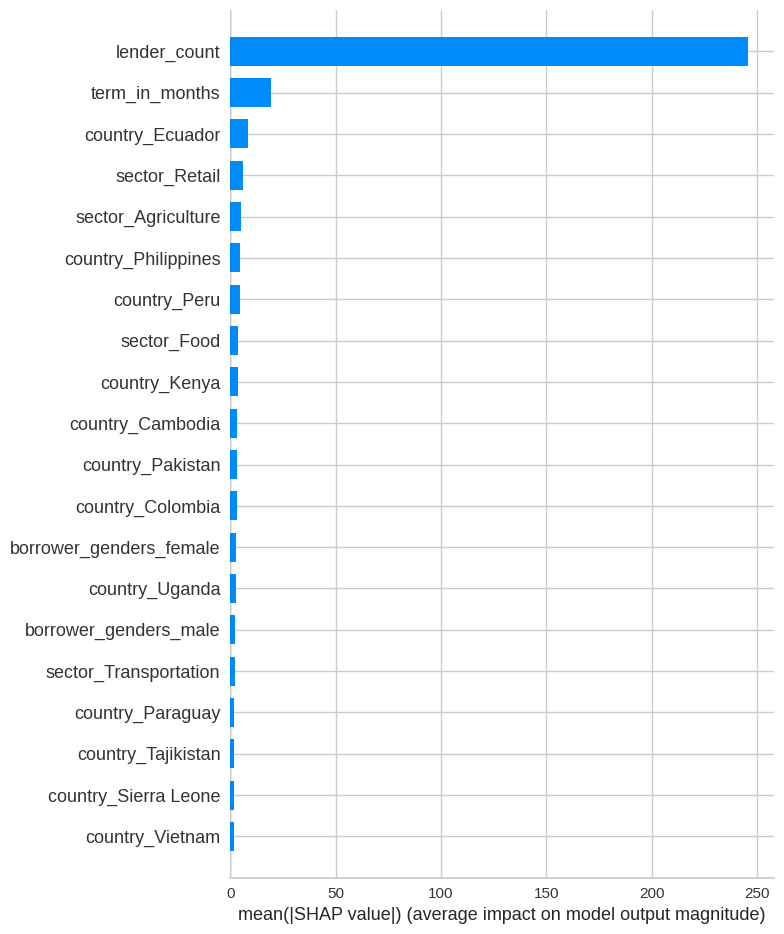

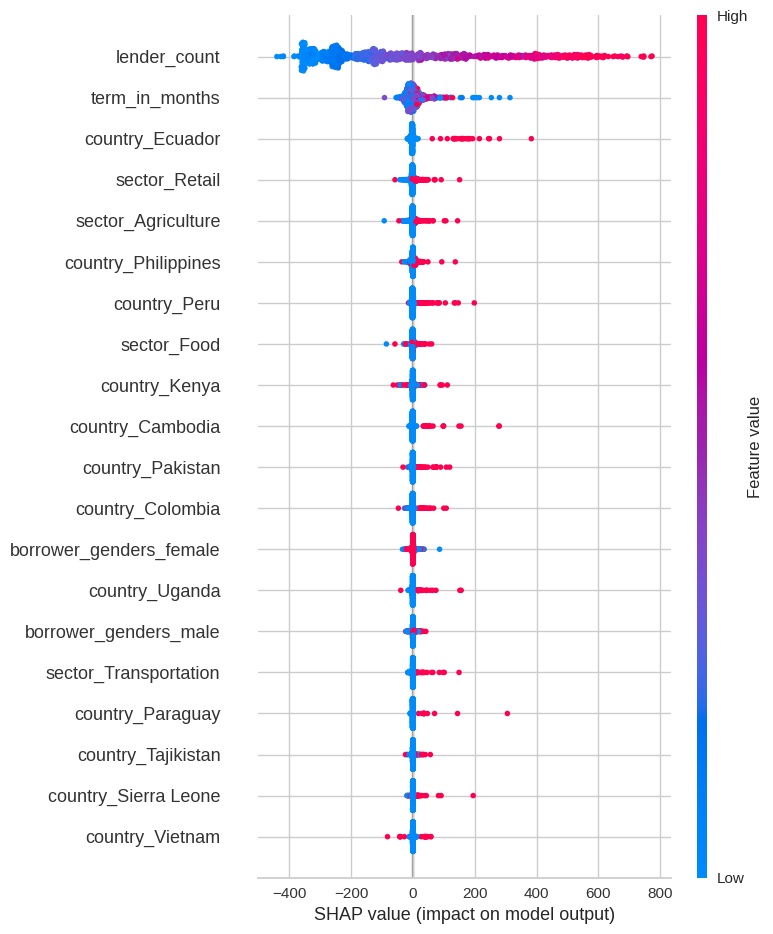

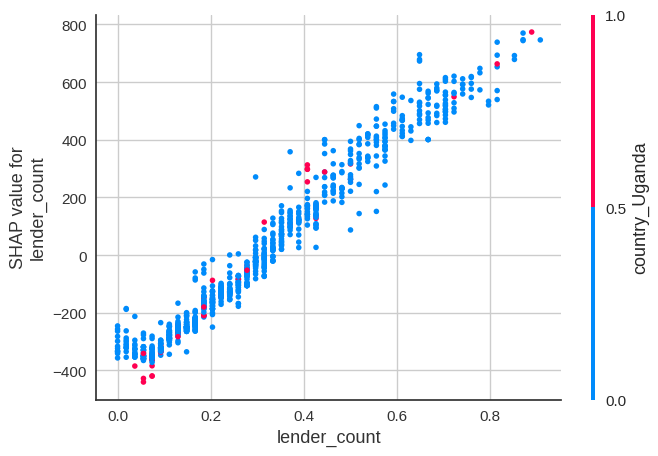

In [ ]:
## Create a SHAP explainer
explainer = shap.TreeExplainer(best_reg)#tjek at det er den rette model
shap_values = explainer.shap_values(X_test)

# Plot feature importances
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP values
shap.summary_plot(shap_values, X_test)

# Plot dependence for the most important feature
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values).mean(0))]
shap.dependence_plot(most_important_feature, shap_values, X_test)

The first plot is the features importance: the features that are most important in driving the loan up or down.

The second plot: show how different feature values (low or high) affect the output.

Plot three is dependence plot

##Reflection on Supervised learning Model Selection and Training
We initially considered combining the variables "use" and "activity" into a single composite variable through Principal Component Analysis (PCA). However, upon further evaluation, we determined that PCA was not necessary due to the limited number of relevant variables available.

We proceeded to run three models—Ordinary Least Squares (OLS), Elastic Net (EL), and Random Forest (RF)—and obtained the following results:

Model OLS -8.383459414639738e+17

Model EL 0.20170123546470542

Model RF 0.8698581305833759

The Random Forest model demonstrated the best performance. After applying hyperparameter tuning, we observed a decrease in the performance to 0.8265322675108029, thus not worth proceding with, although when previously testing it with larger parts of the datset, we saw an increase after hyperparameter tuning, but decided to not do it, as it took hours to run.

Due to computational constraints, we had to reduce our dataset from an initial size of over 500,000 rows to just 5,000 rows in order to run the models efficiently, particularly when using platforms like Streamlit instead of Google Colab. While we managed to run models on 100,000 rows, this required several hours, during which we observed a more pronounced improvement in model performance, especially with hyperparameter tuning. Unfortunately, the need to reduce the dataset size to accommodate platform limitations restricted our ability to fully exploit the models' capabilities.